## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [83]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [84]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [85]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [86]:
# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [87]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([mirna_tumor, mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = mirna_tumor.shape[0]
n_normal = mirna_normal.shape[0]

# Drop categorical columns
mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

# Drop duplicate columns names (Gene symbols with same name)
_, i = np.unique(gene_exp_tumor.columns, return_index=True)
gene_exp_tumor = gene_exp_tumor.iloc[:, i]
gene_exp_normal = gene_exp_normal.iloc[:, i]

print "mirna_tumor", mirna_tumor.shape, 'nulls:', mirna_tumor.isnull().sum().sum()
print "gene_exp_tumor", gene_exp_tumor.shape, 'nulls:', gene_exp_tumor.isnull().sum().sum()
print "mirna_normal", mirna_normal.shape, 'nulls:', mirna_normal.isnull().sum().sum()
print "gene_exp_normal", gene_exp_normal.shape, 'nulls:', gene_exp_normal.isnull().sum().sum()

NaN            7
Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


mirna_tumor (503, 1881) nulls: 0
gene_exp_tumor (503, 20484) nulls: 0
mirna_normal (20, 1881) nulls: 0
gene_exp_normal (20, 20484) nulls: 0


## Univariate feature selection via FDR

In [73]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

(523, 335)
(523, 4275)


## Loading TargetScan database for predicted miRNA-targets interactions

In [88]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs

In [92]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(dys_threshold=0.6)
network.train(miRNAs_tumor=mirna_tumor, targets_tumor=gene_exp_tumor,
              miRNAs_normal=mirna_normal, targets_normal=gene_exp_normal,
              putative_assocs=targetScan_df)
# print nx.bipartite.sets(network.B)

n_A 503
n_B 20


1881
20484
edges 2301


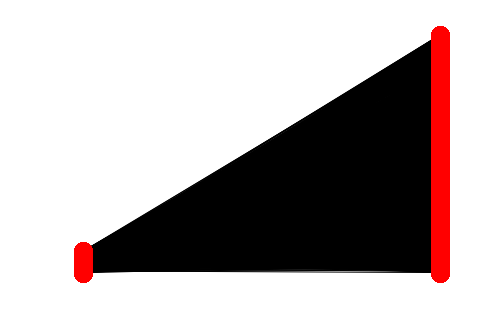

In [130]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(miRNAs_nodes))  # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(targets_nodes))  # put nodes from Y at x=2
nx.draw(network.B, pos=pos)
plt.figure(figsize=(10, 100))
plt.show()

## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target

In [157]:
from collections import OrderedDict
print len(miRNAs_nodes_degrees)
print len(targets_nodes_degrees)

import operator
sorted_miRNAs_nodes_degrees = sorted(miRNAs_nodes_degrees.items(), key=operator.itemgetter(1), reverse=True)
sorted_targets_nodes_degrees = sorted(targets_nodes_degrees.items(), key=operator.itemgetter(1), reverse=True)

mirna_groups = OrderedDict((miRNA, -1) for miRNA in mirna_list)

group_number = 1
# For every target, find its neighbor miRNA's, which forms a group.
# The miRNA's in a groups are then assigned a corresponding number
for (target, n_neighbors) in sorted_targets_nodes_degrees:
    if n_neighbors > 1:
        miRNA_group = network.B.neighbors(target)
        print miRNA_group, group_number
        for miRNA in miRNA_group:
            mirna_groups[miRNA] = group_number
        group_number += 1

# Ensure the rest of the miRNAs not in groups to have unique group number
for miRNA, group_assg in mirna_groups.iteritems():
    if group_assg == -1:
        mirna_groups[miRNA] = group_number
        group_number += 1
    
print mirna_groups
# print group_number

# print map(network.B.neighbors, network.B.neighbors(sorted_miRNAs_nodes_degrees[0][0]))

1881
20484
['hsa-mir-15a', 'hsa-mir-590', 'hsa-mir-21', 'hsa-mir-301a', 'hsa-mir-454', 'hsa-mir-23a', 'hsa-mir-182', 'hsa-mir-27a', 'hsa-mir-130a', 'hsa-mir-32', 'hsa-mir-30b', 'hsa-mir-96'] 1
['hsa-mir-520a', 'hsa-mir-200c', 'hsa-mir-519d', 'hsa-mir-340', 'hsa-mir-490', 'hsa-mir-98', 'hsa-mir-30a', 'hsa-mir-877', 'hsa-mir-93', 'hsa-mir-425', 'hsa-mir-30e'] 2
['hsa-let-7b', 'hsa-let-7c', 'hsa-mir-505', 'hsa-let-7d', 'hsa-mir-520f', 'hsa-mir-520a', 'hsa-mir-98', 'hsa-mir-526b', 'hsa-mir-372', 'hsa-mir-222'] 3
['hsa-mir-20a', 'hsa-mir-20b', 'hsa-mir-27a', 'hsa-mir-301a', 'hsa-mir-454', 'hsa-mir-26b', 'hsa-mir-144', 'hsa-mir-142', 'hsa-mir-32', 'hsa-mir-30a'] 4
['hsa-mir-15a', 'hsa-mir-301a', 'hsa-mir-19a', 'hsa-mir-107', 'hsa-mir-142', 'hsa-mir-130a', 'hsa-mir-185', 'hsa-mir-32', 'hsa-mir-6838', 'hsa-mir-363'] 5
['hsa-mir-520a', 'hsa-mir-520b', 'hsa-mir-520e', 'hsa-mir-520d', 'hsa-mir-148b', 'hsa-mir-152', 'hsa-mir-526b', 'hsa-mir-519d', 'hsa-mir-372'] 6
['hsa-mir-22', 'hsa-mir-301a', 'h

## Loading DIANA-TarBase database for experimentally validated miRNA-targets interactions

In [12]:
# Load data frame from file
tarBase_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TarBase_Experiment_Valid_miRNA-Targets.csv'), delimiter='\t')

# # Select only homo sapiens miRNA-target pairs
tarBase_df = tarBase_df[tarBase_df["species"] == "Homo sapiens"]
tarBase_df = tarBase_df[tarBase_df["positive_negative"] == "NEGATIVE"]
tarBase_df = tarBase_df[tarBase_df["condition"] == "NEGATIVE"]
# tarBase_df = tarBase_df[["miRNA_mature_ID", "Target gene_name"]]
# 
# # Standardize miRNA and gene symbols
# tarBase_df['miRNA_mature_ID'] = tarBase_df['miRNA_mature_ID'].str.lower()
# tarBase_df['miRNA_mature_ID'] = tarBase_df['miRNA_mature_ID'].str.replace('*', '')
# tarBase_df['Target gene_name'] = tarBase_df['Target gene_name'].str.upper()
# 
# # Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets 
# tarBase_df = tarBase_df[tarBase_df["miRNA_mature_ID"].isin(mirna_list) &
#                             tarBase_df["Target gene_name"].isin(gene_symbols)]
print tarBase_df.columns
tarBase_df

Index([u'geneId', u'geneName', u'mirna', u'species', u'cell_line', u'tissue',
       u'category', u'method', u'positive_negative', u'direct_indirect',
       u'up_down', u'condition'],
      dtype='object')


,geneId,geneName,mirna,species,cell_line,tissue,category,method,positive_negative,direct_indirect,up_down,condition
232,ALK7,ALK7,hsa-miR-376c-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,DOWN,NaN
359,Bcl-xL,Bcl-xL,hsa-miR-122-5p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,NaN,NaN
360,Bcl-xL,Bcl-xL,hsa-miR-122-5p,Homo sapiens,NaN,NaN,NaN,Western Blot,NEGATIVE,INDIRECT,NaN,NaN
433,C12ORF31,C12ORF31,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,Microarrays,NEGATIVE,INDIRECT,DOWN,NaN
469,C18orf37,C18orf37,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
477,C20ORF77,C20ORF77,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
525,C9ORF19,C9ORF19,hsa-miR-124-3p,Homo sapiens,NaN,NaN,NaN,pSILAC,NEGATIVE,INDIRECT,DOWN,NaN
579,c-met,c-met,hsa-miR-23b-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,DOWN,NaN
588,c-MYC,c-MYC,hsa-let-7g-5p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,NaN,NaN
707,E-cadherin,E-cadherin,hsa-miR-200c-3p,Homo sapiens,NaN,NaN,NaN,qPCR,NEGATIVE,INDIRECT,UP,NaN


In [20]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

ELMSAN1 hsa-mir-133b
ITM2A hsa-mir-1293
hsa-mir-1238 CD101
hsa-mir-1238 CCDC141
DNAJC27 hsa-mir-133b
MAFF hsa-mir-133b
UQCC3 hsa-mir-1293
ANO2 hsa-mir-133a-2
NFKBIZ hsa-mir-133b
hsa-mir-133a-2 WFIKKN2
hsa-mir-1246 CACNA1S
hsa-mir-133b KDM6B
hsa-mir-133b CDC7
hsa-mir-1181 CACNA1S
hsa-mir-1293 PDCD6
hsa-mir-1293 MRPL21
hsa-mir-1293 ACTL6A
0.0


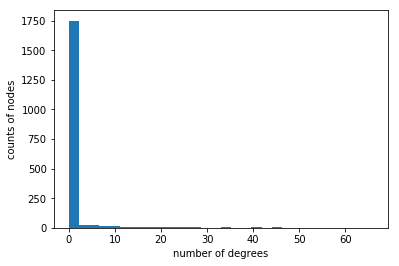

In [114]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 22,
 1,
 0,
 0,
 22,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 4,
 16,
 17,
 0,
 0,
 0,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 48,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 7,
 1,
 3,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 37,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 1,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,